In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from models import save_model, generate_model_CNN, plot_performance
from generators import generator, decode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
save_dir = 'plots'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

# X_load = np.load('../data/processed_data/m4019_session1/X.npy')
# Y_load_flat = np.load('../data/processed_data/m4019_session1/y.npy')


# enc = OneHotEncoder(categories='auto')
# Y_load = enc.fit_transform(Y_load_flat.reshape(-1, 1) ,).toarray()

# split_index = int(X_load.shape[0]*0.8)
    
# X_train = X_load[:split_index]
# Y_train = Y_load[:split_index]
# # V_train = V_load[:split_index]

# X_val = X_load[split_index:]
# Y_val = Y_load[split_index:]
# # V_val = V_load[split_index:]


X_train = np.load('../data/processed_data/X_train.npy')
Y_train_flat = np.load('../data/processed_data/y_train.npy')

enc = OneHotEncoder(categories='auto')
Y_train = enc.fit_transform(Y_train_flat.reshape(-1, 1) ,).toarray()


X_val = np.load('../data/processed_data/X_test.npy')
Y_val_flat = np.load('../data/processed_data/y_test.npy')

enc = OneHotEncoder(categories='auto')
Y_val = enc.fit_transform(Y_val_flat.reshape(-1, 1) ,).toarray()

In [9]:
batch_size = 500
time_window = 100
n_dim = 1
class_weight = {0: 1., 1: 50.,}
predict_early = 0

input_shape = (time_window, n_dim)

In [10]:
train_generator = generator(X_train, Y_train, batch_size, time_window, predict_early=predict_early)
validate_generator = generator(X_val, Y_val, batch_size, time_window, predict_early=predict_early)

In [11]:
model = generate_model_CNN(input_shape)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 20)           160       
_________________________________________________________________
average_pooling1d_1 (Average (None, 50, 20)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 20)            80        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 20)            2820      
_________________________________________________________________
average_pooling1d_2 (Average (None, 25, 20)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 20)            80        
__________

In [12]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=1000,
                              epochs=15, 
                              verbose=1,
                              validation_data=validate_generator,
                              validation_steps=1000,
                              class_weight=class_weight, )

save_model(model, name=predict_early)

Epoch 1/15
1000/1000 [==============================] - 169s 169ms/step - loss: 1.3154 - acc: 0.6973 - val_loss: 3.5709 - val_acc: 0.0429
Epoch 2/15
1000/1000 [==============================] - 105s 105ms/step - loss: 1.0165 - acc: 0.7877 - val_loss: 0.2539 - val_acc: 0.9236
Epoch 3/15
1000/1000 [==============================] - 121s 121ms/step - loss: 1.0590 - acc: 0.7856 - val_loss: 0.1355 - val_acc: 0.9603
Epoch 4/15
1000/1000 [==============================] - 144s 144ms/step - loss: 0.9436 - acc: 0.8011 - val_loss: 0.1156 - val_acc: 0.9621
Epoch 5/15
1000/1000 [==============================] - 234s 234ms/step - loss: 0.9379 - acc: 0.8025 - val_loss: 0.1114 - val_acc: 0.9630
Epoch 6/15
1000/1000 [==============================] - 237s 237ms/step - loss: 0.8706 - acc: 0.8059 - val_loss: 4.2937 - val_acc: 0.0425
Epoch 7/15
1000/1000 [==============================] - 204s 204ms/step - loss: 0.8155 - acc: 0.8135 - val_loss: 2.3503 - val_acc: 0.1632
Epoch 8/15
1000/1000 [============

<IPython.core.display.Javascript object>


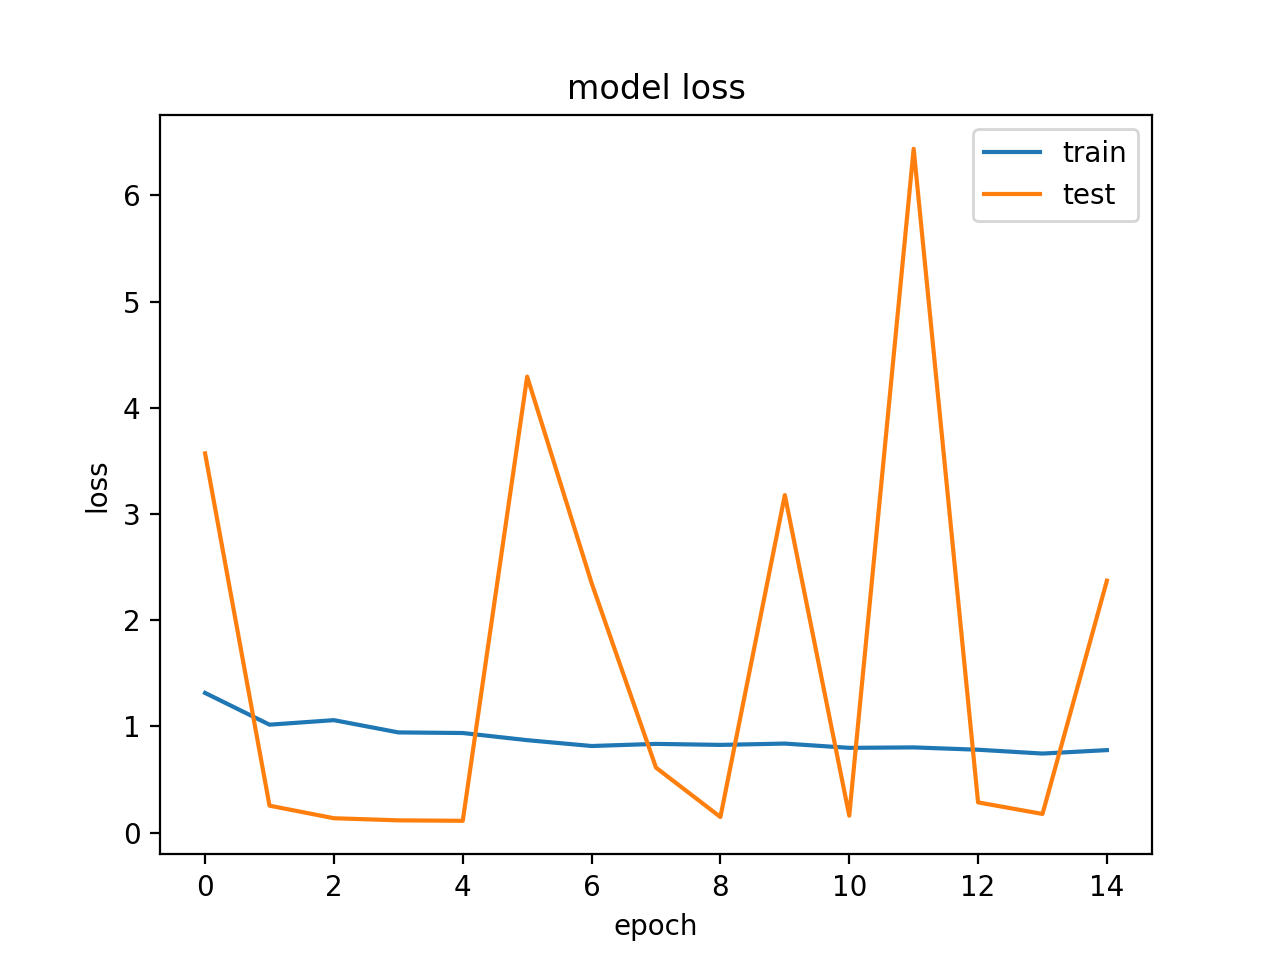

<IPython.core.display.Javascript object>


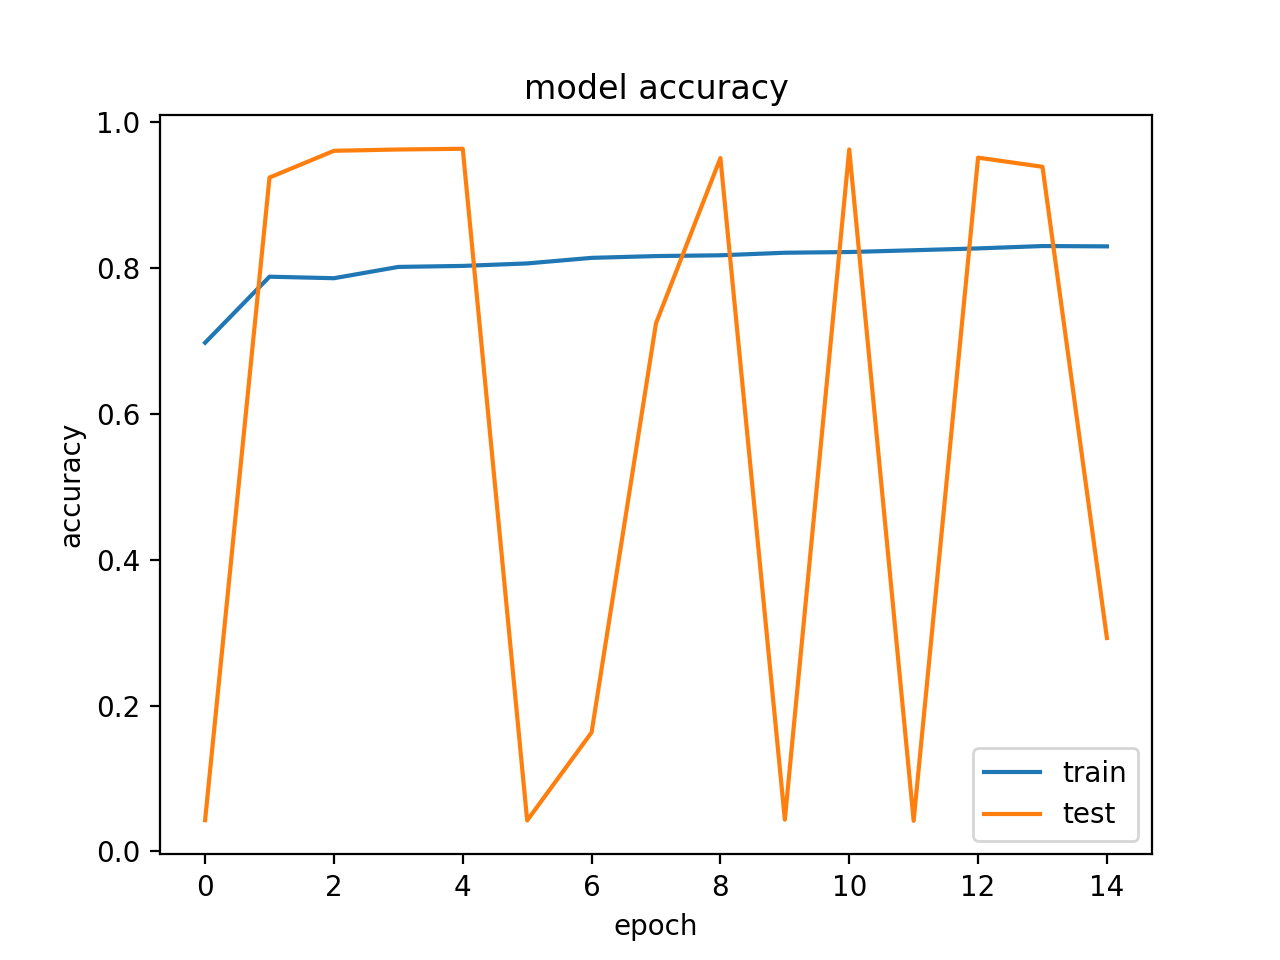

In [13]:
plot_performance(history)

In [ ]:
validate_generator = generator(X_val, Y_val, batch_size*100, time_window)

In [14]:
X_trial, y_trial, = next(validate_generator)
res = model.predict(X_trial)

In [15]:
threshold=0.9999
y_true = decode(y_trial, threshold=threshold)
y_pred = decode(res, threshold=threshold)

weights = np.zeros_like(y_true)
weights[y_true==0] = 1
weights[y_true==1] = 100


In [16]:
from sklearn.metrics import balanced_accuracy_score, recall_score, classification_report, confusion_matrix

print(balanced_accuracy_score(y_true, y_pred, adjusted=True))
print(recall_score(y_true, y_pred, average='weighted'))

target_names = ['no ripple', 'ripple',]
print(classification_report(y_true, y_pred, target_names=target_names))

-0.002049180327868827
0.974
              precision    recall  f1-score   support

   no ripple       0.98      1.00      0.99       488
      ripple       0.00      0.00      0.00        12

   micro avg       0.97      0.97      0.97       500
   macro avg       0.49      0.50      0.49       500
weighted avg       0.95      0.97      0.96       500



In [17]:
conv_matrix = confusion_matrix(y_true, y_pred)
print(conv_matrix)
conv_matrix = conv_matrix.astype('float') / conv_matrix.sum(axis=1)[:, np.newaxis]
print(conv_matrix)

[[487   1]
 [ 12   0]]
[[0.99795082 0.00204918]
 [1.         0.        ]]


In [ ]:
plt.figure()
plt.plot(y_true)
plt.plot(y_pred+1)
plt.show()

In [ ]:
plt.figure()
plt.plot(X_load)
plt.plot(Y_load_flat)
plt.show()

In [ ]:
Y_load.shape

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)